In [140]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import numpy as np
from sklearn.model_selection import train_test_split


In [141]:
# REFERENCE:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [142]:
train_data_set = np.load("fashion_train.npy")
test_data_set = np.load("fashion_test.npy")


# We have 10000 images in the training set
len(train_data_set)

# To find classification for each element, the last value in the set is:
# 0 for T-shirt/top
# 1 for Trousers
# 2 for Pullover
# 3 for Dress
# 4 for Shirt
len(train_data_set[0])

785

In [152]:
# We need to clean the array, as the last value is the classification. Let's first save these separately.

train_classes = []

for i in range(len(train_data_set)):
    train_classes.append(train_data_set[i][784])
      
train_classes = np.array(train_classes)
#train_classes = train_classes.reshape(-1, 1)


test_classes = []

for i in range(len(test_data_set)):
    test_classes.append(test_data_set[i][784])
      
test_classes = np.array(test_classes)
#test_classes = test_classes.reshape(-1, 1)

In [153]:
# Now we can delete the last element and have a cleaned training set that we can work with.

cleaned_train_set = np.empty((len(train_data_set), 784), dtype=np.uint8)

for i in range(len(train_data_set)):
    temp = np.delete(train_data_set[i], 784)
    cleaned_train_set[i] = temp
    
    
cleaned_test_set = np.empty((len(test_data_set), 784), dtype=np.uint8)

for i in range(len(test_data_set)):
    temp = np.delete(test_data_set[i], 784)
    cleaned_test_set[i] = temp

In [154]:
# We reshape it so that the 1D array becomes a 2D 28x28 array. 
# We also need to save the number of channels in the second value for our CNN to work.
cleaned_train_set_reshaped = cleaned_train_set.reshape(-1, 1, 28, 28)
cleaned_test_set_reshaped = cleaned_test_set.reshape(-1, 1, 28, 28)

In [155]:
X_train, X_val, y_train, y_val = train_test_split(cleaned_train_set_reshaped, train_classes, test_size = 0.25)

In [156]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(cleaned_test_set_reshaped, dtype=torch.float32)

# Assuming the labels are available as y_train and y_val
# Convert labels to PyTorch tensors
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(test_classes, dtype=torch.long)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [157]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Our convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 5, padding = 2) # Padding of 2 ensures that we keep the images at 28x28 with a kernel_size of 5
        self.pool = nn.MaxPool2d(2, 2) # Pooling reduces the size of the image by half
        self.conv2 = nn.Conv2d(32, 64, 5, padding = 2)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)
        

    def forward(self, x):
        '''
        The forward function defines how our data flows through our convolution network, as defined above.
        '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # PROBLEM SOLVING
        # Check the shape before flattening
        #print(f"Shape before flattening: {x.shape}")  # Debugging line
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        # PROBLEM SOLVING
        # Check the shape after flattening
        #print(f"Shape after flattening: {x.shape}")  # Debugging line
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

# Initialize the model
model = CNN()

In [158]:
# Little function for checking the correct shapes for the step to fc1
def calculate_flattened_size(model, input_shape=(1, 1, 28, 28)):
    x = torch.randn(input_shape)
    x = model.pool(F.relu(model.conv1(x)))
    x = model.pool(F.relu(model.conv2(x)))
    return x.shape[1] * x.shape[2] * x.shape[3]

flattened_size = calculate_flattened_size(model)
print(flattened_size)
#model.fc1 = nn.Linear(flattened_size, 120)

3136


In [159]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)       
#optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam does not use momentum

In [160]:
total_epochs = 100
patience = 5
patience_reactions = ('','Getting a little impatient here','Seriously, getting rather impatient','I am getting seriously impatient...', 'Now you\'re really testing me!', 'My patience is done. Terminating')
patience_counter = 0

for epoch in range(total_epochs):  # loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {running_loss/len(train_loader)}")
    
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Don't compute gradients during validation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Accuracy: {100 * correct / total}%")
    if running_loss/len(train_loader) < 0.1:
        patience_counter += 1
        print(patience_reactions[patience_counter])
    if patience_counter == patience:
        break

print('Finished Training')

Epoch [1/100], Loss: 0.7744666351857832
Validation Accuracy: 80.84%
Epoch [2/100], Loss: 0.43438249131885626
Validation Accuracy: 85.68%
Epoch [3/100], Loss: 0.3600624624197766
Validation Accuracy: 86.2%
Epoch [4/100], Loss: 0.31353223475359254
Validation Accuracy: 86.84%
Epoch [5/100], Loss: 0.2917339265093965
Validation Accuracy: 86.6%
Epoch [6/100], Loss: 0.24746789871636082
Validation Accuracy: 87.92%
Epoch [7/100], Loss: 0.2207591801376666
Validation Accuracy: 86.08%
Epoch [8/100], Loss: 0.20706258480579165
Validation Accuracy: 86.24%
Epoch [9/100], Loss: 0.18510572096111916
Validation Accuracy: 87.8%
Epoch [10/100], Loss: 0.1678283881017212
Validation Accuracy: 89.12%
Epoch [11/100], Loss: 0.14624997162086478
Validation Accuracy: 87.52%
Epoch [12/100], Loss: 0.12194310824812973
Validation Accuracy: 84.32%
Epoch [13/100], Loss: 0.13750387801812425
Validation Accuracy: 86.4%
Epoch [14/100], Loss: 0.11183155907349566
Validation Accuracy: 88.52%
Epoch [15/100], Loss: 0.09509084390286

In [ ]:
# If we want to save our model, set a path:
PATH = './fashion_cnn_model.pth'
torch.save(model.state_dict(), PATH)

In [161]:
classes = ('t-shirt/top', 'trousers', 'pullovers', 'dresses', 'shirts')

#### Class accuracy for validation data

In [162]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


combined_accuracy = 0.0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    combined_accuracy += accuracy
    
combined_accuracy = combined_accuracy/5

print(f'The combined accuracy of our model for validation data is: {combined_accuracy:.1f}%')

Accuracy for class: t-shirt/top is 73.5 %
Accuracy for class: trousers is 98.6 %
Accuracy for class: pullovers is 89.1 %
Accuracy for class: dresses is 90.9 %
Accuracy for class: shirts is 83.8 %
The combined accuracy of our model for validation data is: 87.2%


#### Class accuracy for test data

In [168]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


combined_accuracy = 0.0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    combined_accuracy += accuracy
    
    
combined_accuracy = combined_accuracy/5

print(f'The combined accuracy of our model for test data is: {combined_accuracy:.1f}%')

Accuracy for class: t-shirt/top is 72.2 %
Accuracy for class: trousers is 98.1 %
Accuracy for class: pullovers is 85.8 %
Accuracy for class: dresses is 92.7 %
Accuracy for class: shirts is 81.3 %
The combined accuracy of our model for test data is: 86.0%


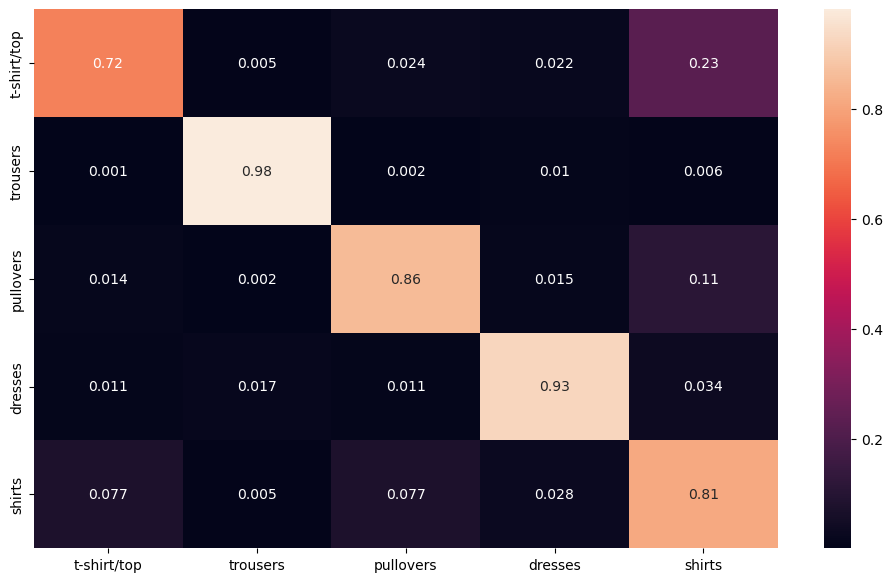

In [167]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')